In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install tensorflow --upgrade tensorflow

In [ ]:
!pip install --upgrade deepxde


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Constantes de Lamé
lam = 1.0
mu = 1.0

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
# Domaine
geom = dde.geometry.Rectangle([0, 0], [1, 1])

In [ ]:
# Solution exacte
def u_exact(x):
    u1 = np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])
    u2 = np.cos(np.pi * x[:, 0]) * np.cos(np.pi * x[:, 1])
    return np.stack([u1, u2], axis=-1)

In [ ]:
# Terme de force calculé à partir de la solution exacte
def force_term(x):
    pi = tf.constant(np.pi, dtype=tf.float32)
    x1, x2 = x[:, 0:1], x[:, 1:2]

    # Calcul du terme de force à partir de la solution exacte
    f1 = (2 * mu ) * pi ** 2 * tf.sin(pi * x1) * tf.sin(pi * x2)
    f2 = (2 * mu ) * pi ** 2 * tf.cos(pi * x1) * tf.cos(pi * x2)
    return tf.concat([f1, f2], axis=1)

In [ ]:
# Conditions aux limites
def left(x, on_boundary): return on_boundary and np.isclose(x[0], 0)
def right(x, on_boundary): return on_boundary and np.isclose(x[0], 1)
def bottom(x, on_boundary): return on_boundary and np.isclose(x[1], 0)
def top(x, on_boundary): return on_boundary and np.isclose(x[1], 1)

In [ ]:
# Use the exact solution at boundaries
def bc_func(x):
    u1 = np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])
    u2 = np.cos(np.pi * x[:, 0]) * np.cos(np.pi * x[:, 1])
    return np.stack([u1, u2], axis=-1)

In [ ]:
# Define boundary conditions using the exact solution
bc = [
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 0:1], left, component=0),
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 1:2], left, component=1),
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 0:1], right, component=0),
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 1:2], right, component=1),
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 0:1], bottom, component=0),
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 1:2], bottom, component=1),
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 0:1], top, component=0),
    dde.DirichletBC(geom, lambda x: bc_func(x)[:, 1:2], top, component=1),
]

In [ ]:
def pde(x, u):
    # u is a tensor with shape (N, 2): N points, 2 displacement components (u1, u2)
    u1 = u[:, 0:1]  # Displacement in x-direction
    u2 = u[:, 1:2]  # Displacement in y-direction

    # Compute spatial derivatives using dde.grad.jacobian
    u1_x = dde.grad.jacobian(u1, x, i=0, j=0)  # du1/dx
    u1_y = dde.grad.jacobian(u1, x, i=0, j=1)  # du1/dy
    u2_x = dde.grad.jacobian(u2, x, i=0, j=0)  # du2/dx
    u2_y = dde.grad.jacobian(u2, x, i=0, j=1)  # du2/dy

    # Deformation (strain)
    eps_xx = u1_x
    eps_yy = u2_y
    eps_xy = 0.5 * (u1_y + u2_x)

    # Stress (Hooke's law)
    trace = eps_xx + eps_yy
    sigma_xx = lam * trace + 2 * mu * eps_xx
    sigma_yy = lam * trace + 2 * mu * eps_yy
    sigma_xy = 2 * mu * eps_xy

    # Compute derivatives of stresses
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)  # d(sigma_xx)/dx
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)  # d(sigma_xy)/dy
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)  # d(sigma_xy)/dx
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)  # d(sigma_yy)/dy

    # Force terms
    f = force_term(x)
    fx, fy = f[:, 0:1], f[:, 1:2]

    # Formulate PDE residuals
    eq1 = sigma_xx_x + sigma_xy_y + fx
    eq2 = sigma_xy_x + sigma_yy_y + fy
    return [eq1, eq2]

In [ ]:
# Données
data = dde.data.PDE(
    geom, pde, bc,
    num_domain=1000,
    num_boundary=100,
    solution=u_exact,
    num_test=200,
)

In [ ]:
# Réseau
net = dde.nn.FNN([2] + [60] * 2 + [2], "tanh", "Glorot normal")

In [ ]:
# Create DeepXDE model
model = dde.Model(data, net) # This line is added

# Compilation avec Adam
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.105081 s

'compile' took 1.935053 s



In [ ]:
# Entraînement initial avec Adam
losshistory, train_state = model.train(iterations=800000)

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric   
0         [8.99e+01, 1.06e+02, 1.05e-02, 3.60e-01, 2.46e-02, 7.04e-01, 1.41e-03, 5.37e-01, 4.03e-02, 6.43e-01]    [1.12e+02, 8.47e+01, 1.05e-02, 3.60e-01, 2.46e-02, 7.04e-01, 1.41e-03, 5.37e-01, 4.03e-02, 6.43e-01]    [1.02e+00]    
1000      [3.90e-02, 2.72e-02, 6.30e-03, 1.33e-03, 2.02e-02, 1.94e-02, 5.20e-03, 3.71e-03, 7.79e-03, 1.29e-02]    [2.88e-02, 1.79e-02, 6.30e-03, 1.33e-03, 2.02e-02, 1.94e-02, 5.20e-03, 3.71e-03, 7.79e-03, 1.29e-02]    [1.63e-01]    
2000      [1.10e-02, 4.38e-03, 1.21e-03, 5.08e-04, 4.29e-03, 5.21e-03, 2.46e-03, 3.38e-03, 2.56e-03, 2.14e-03]    [7.98e-03, 2.58e-03, 1.21e-03, 5.08e-04, 4.29e-03, 5.21e-03, 2.46e-03, 3.38e-03, 2.56e-03, 2.14e-03]    [8.18e-02]    
3000      [6.65e-03, 2.55e-03, 6.08e-04, 6.48e-04

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


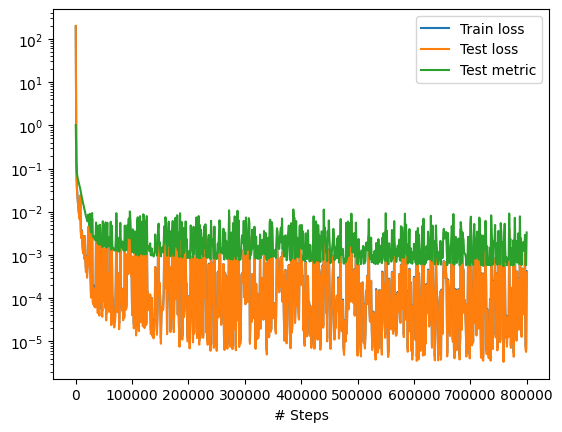

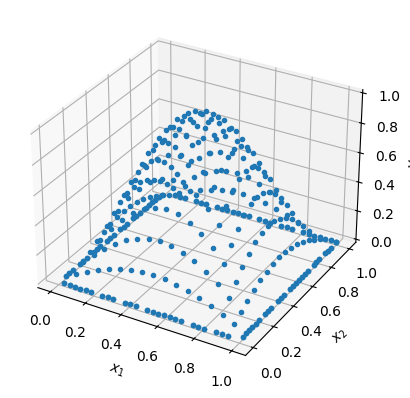

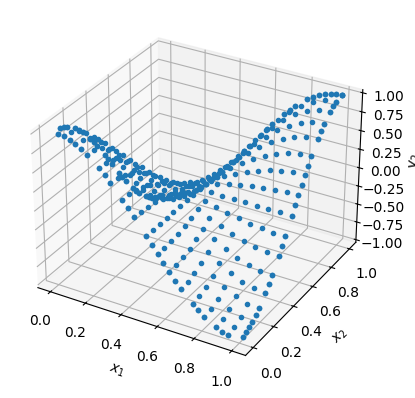

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


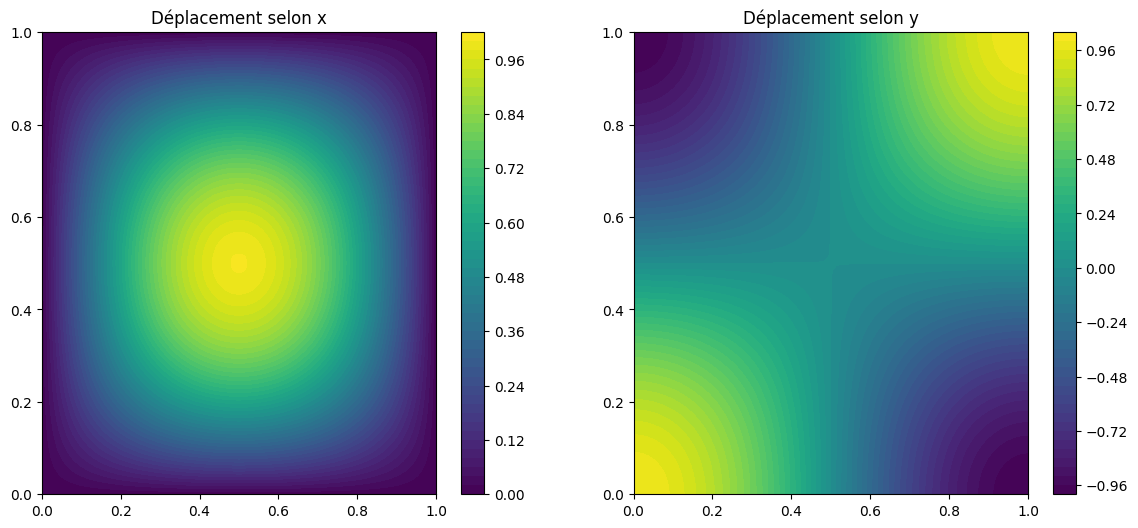

In [ ]:
# Prédiction
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy = np.vstack((X.flatten(), Y.flatten())).T
pred = model.predict(xy)
U1 = pred[:, 0].reshape(X.shape)
U2 = pred[:, 1].reshape(X.shape)

# Visualisation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
c1 = ax[0].contourf(X, Y, U1, 50, cmap="viridis")
fig.colorbar(c1, ax=ax[0])
ax[0].set_title("Déplacement selon x")
c2 = ax[1].contourf(X, Y, U2, 50, cmap="viridis")
fig.colorbar(c2, ax=ax[1])
ax[1].set_title("Déplacement selon y")
plt.show()



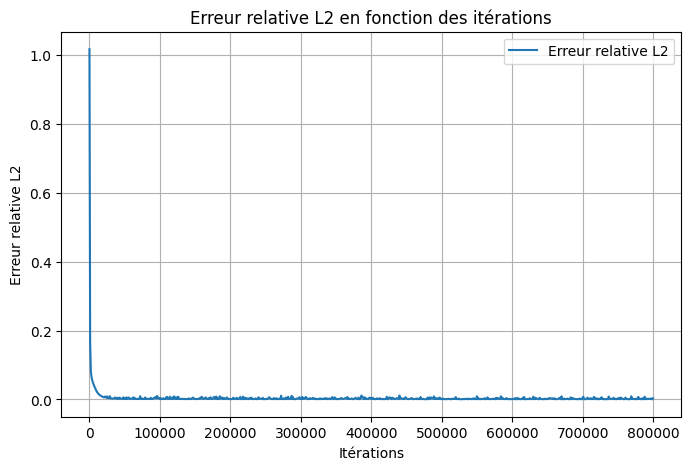

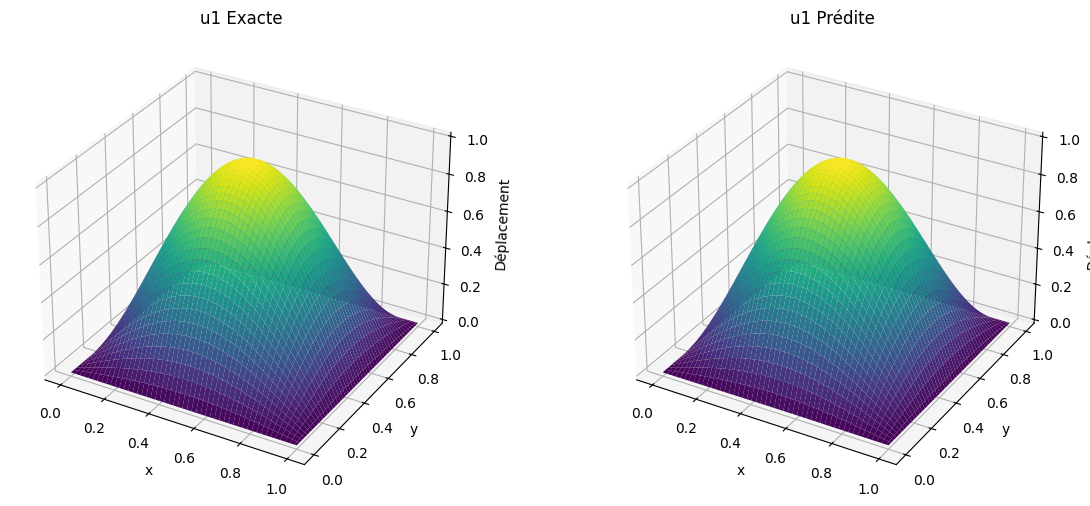

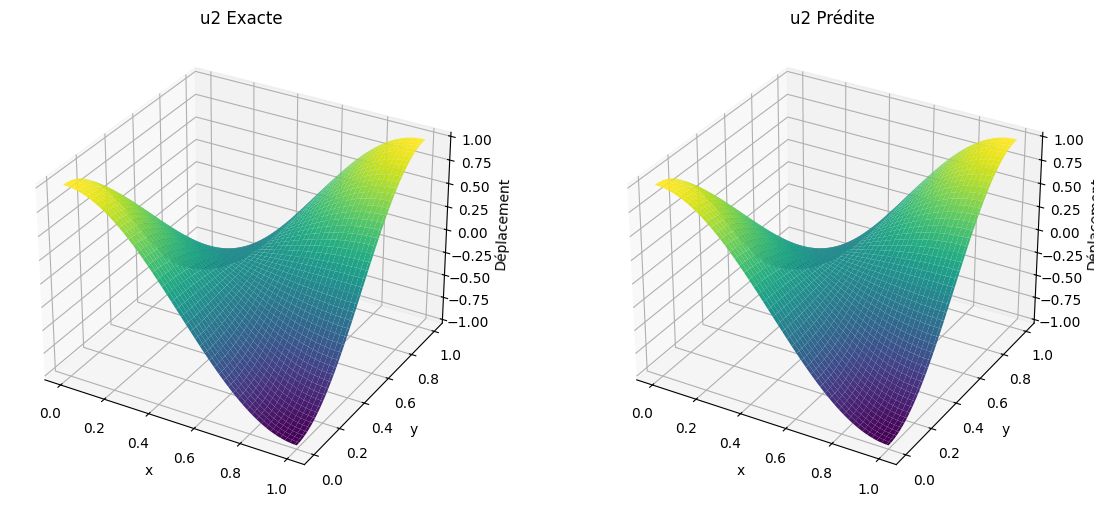

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour tracer l'erreur relative L2 en fonction des itérations
def plot_error(losshistory):
    # Conversion des données en tableaux numpy
    steps = np.array(losshistory.steps)
    metrics = np.array(losshistory.metrics_test)

    # Traçage de l'erreur L2 (première métrique)
    plt.figure(figsize=(8, 5))
    plt.plot(steps, metrics[:, 0], label="Erreur relative L2")
    plt.xlabel("Itérations")
    plt.ylabel("Erreur relative L2")
    plt.title("Erreur relative L2 en fonction des itérations")
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer la solution exacte et prédite en 3D
def plot_3d(X, Y, exact, predicted, title):
    fig = plt.figure(figsize=(14, 6))

    # Solution exacte
    ax1 = fig.add_subplot(121, projection="3d")
    ax1.plot_surface(X, Y, exact, cmap="viridis", edgecolor="none")
    ax1.set_title(f"{title} Exacte")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("Déplacement")

    # Solution prédite
    ax2 = fig.add_subplot(122, projection="3d")
    ax2.plot_surface(X, Y, predicted, cmap="viridis", edgecolor="none")
    ax2.set_title(f"{title} Prédite")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("Déplacement")

    plt.show()

# Appel des fonctions après l'entraînement
# Visualiser l'erreur en fonction des itérations
plot_error(losshistory)

# Visualiser les solutions exacte et prédite en 3D
plot_3d(X, Y, np.sin(np.pi * X) * np.sin(np.pi * Y), U1, "u1")
plot_3d(X, Y, np.cos(np.pi * X) * np.cos(np.pi * Y), U2, "u2")


L2 relative error (u1): 1.996e-02
L2 relative error (u2): 1.977e-02


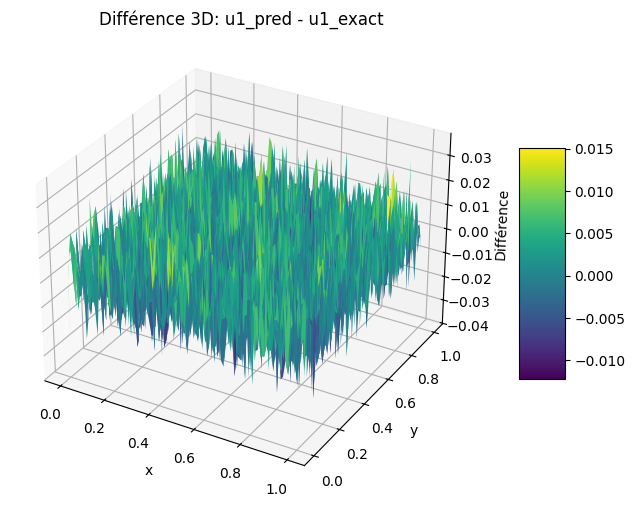

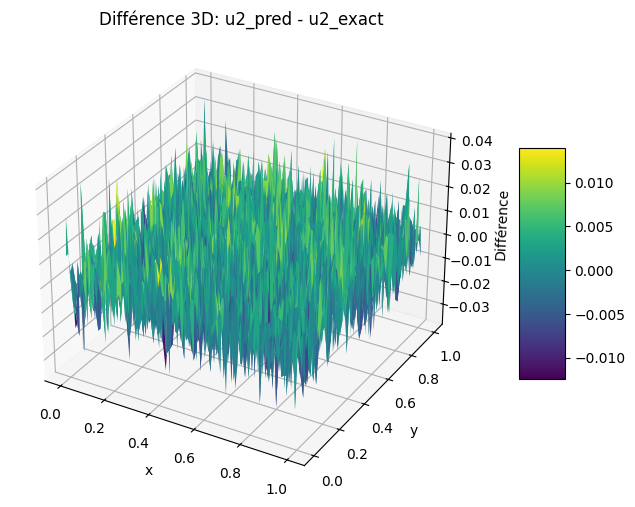

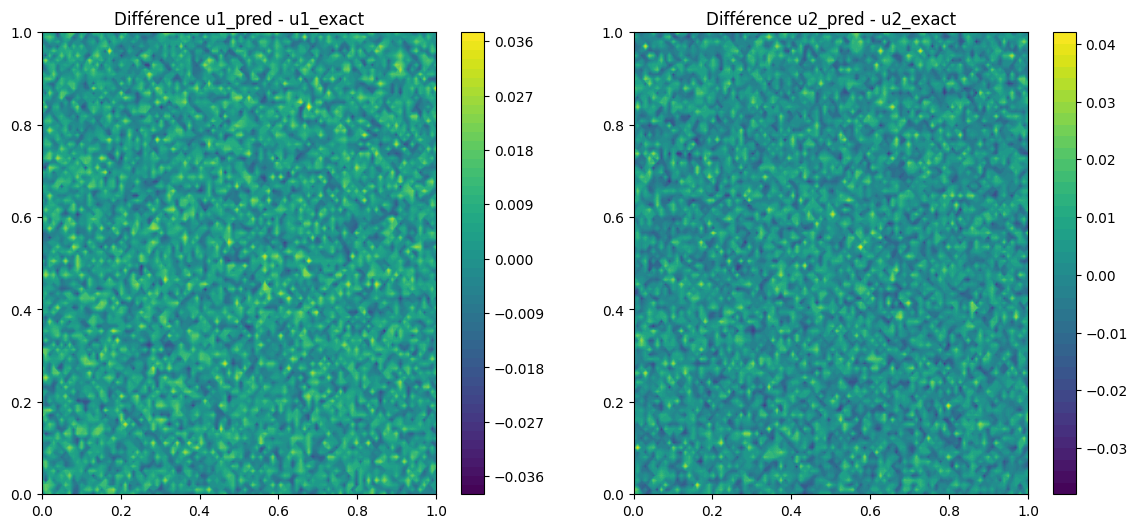

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Define the exact solution
def u_exact(x):
    u1 = np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])
    u2 = np.cos(np.pi * x[:, 0]) * np.cos(np.pi * x[:, 1])
    return np.stack([u1, u2], axis=-1)

# Grid resolution
N = 100
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
xy = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))  # shape (10000, 2)

# Exact solution
u_exact_vals = u_exact(xy)
U1_exact = u_exact_vals[:, 0].reshape(X.shape)
U2_exact = u_exact_vals[:, 1].reshape(X.shape)

# Simulated predicted values with small noise
noise_level = 0.01
U1_pred = U1_exact + noise_level * np.random.randn(*U1_exact.shape)
U2_pred = U2_exact + noise_level * np.random.randn(*U2_exact.shape)

# Compute differences (u_pred - u_exact)
U1_diff = U1_pred - U1_exact
U2_diff = U2_pred - U2_exact

# Compute L2 relative errors
l2_u1 = np.linalg.norm(U1_diff) / np.linalg.norm(U1_exact)
l2_u2 = np.linalg.norm(U2_diff) / np.linalg.norm(U2_exact)

print(f"L2 relative error (u1): {l2_u1:.3e}")
print(f"L2 relative error (u2): {l2_u2:.3e}")

# 3D Plot function
def plot_diff_3d(X, Y, diff, title):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, diff, cmap="viridis", edgecolor="none")
    ax.set_title(f"Différence 3D: {title}_pred - {title}_exact")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Différence")
    ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.zaxis.get_major_formatter().set_scientific(True)
    ax.zaxis.get_major_formatter().set_powerlimits((-3, 3))
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

# Plot differences in 3D
plot_diff_3d(X, Y, U1_diff, "u1")
plot_diff_3d(X, Y, U2_diff, "u2")

# 2D Contour plots of differences
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Contour plot for U1 difference
c1 = ax[0].contourf(X, Y, U1_diff, 50, cmap="viridis")
fig.colorbar(c1, ax=ax[0])
ax[0].set_title("Différence u1_pred - u1_exact")

# Contour plot for U2 difference
c2 = ax[1].contourf(X, Y, U2_diff, 50, cmap="viridis")
fig.colorbar(c2, ax=ax[1])
ax[1].set_title("Différence u2_pred - u2_exact")

plt.show()
